In [1]:
import hashlib
import json
import time

from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
from math import atan2, fabs, pi, pow, sqrt
from multiprocessing import cpu_count, Pool

import geopandas as gpd
import numpy as np
import pandas as pd
import requests

from pytz import timezone
from requests import Session
from shapely.geometry import Point

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

with open('../.config/connections.json') as json_file:  
    connections = json.load(json_file)

In [2]:
plt.rcParams["figure.figsize"] = (16,10)

In [3]:
end_time = datetime(2019, 6, 30, 1) - timedelta(hours=24)
start_time = end_time - timedelta(hours=24)
trip_params = {
    'min_end_time': int(start_time.timestamp()) * 1000,
    'max_end_time': int(end_time.timestamp()) * 1000
}
event_params = {
    'start_time': int(start_time.timestamp()) * 1000,
    'end_time': int(end_time.timestamp()) * 1000
}

In [4]:
print(trip_params)
print(event_params)

{'min_end_time': 1561683600000, 'max_end_time': 1561770000000}
{'start_time': 1561683600000, 'end_time': 1561770000000}


In [5]:
def _request(url, payload_key, params=None, results=[]):
        """
        Internal helper for sending requests.

        Returns payload(s).
        """
        retries = 0
        res = None

        while res is None:
            try:
                res = session.get(url, params=params)
                res.raise_for_status()
            except Exception as err:
                res = None
                retries = retries + 1
                if retries > 3:
                    raise Exception(
                        f"Unable to retrieve response from {url} after {3}.  Aborting...")

                print(
                    f"{err}. Retrying in 10 seconds... (retry {retries}/3)")
                time.sleep(10)

        if "Content-Type" in res.headers:
            cts = res.headers["Content-Type"].split(";")
            if "application/vnd.mds.provider+json" not in cts:
                print(
                    f"Incorrect content-type returned: {res.headers['Content-Type']}")
            cts = cts[1:]
            for ct in cts:
                if ct.strip().startswith("charset"):
                    pass
                if not ct.strip().startswith(f"version=0.3"):
                    print(
                        f"Incorrect content-type returned: {res.headers['Content-Type']}")
        else:
            print(f"Missing {self.version} content-type header.")

        page = res.json()

        if page["data"] is not None:
            results.extend(page["data"][payload_key])

        if "links" in page:
            next_page = page["links"].get("next")
            if next_page is not None:
                results = _request(url=next_page, payload_key=payload_key,
                                        results=results)

        return results

In [6]:
version = '0.3'
trips = []
for provider in ['Lime', 'Spin', 'Bolt', 'Razor', 'Shared']:
    c = connections[provider]
    
    session = Session()
    if 'extra' in c:
        if 'headers' in c['extra']:
            session.headers.update(c['extra']['headers'])
    if 'token_url' in c:
        res = session.post(c['token_url'], data=c['auth_payload'])
        session.headers.update({'Authorization': f'Bearer {res.json()[c["token_key"] if "token_key" in c else "token"]}'})
    session.headers.update({"Accept": f"application/vnd.mds.provider+json;version={version}"})
    
    trips.extend(_request(c['host'].replace(':endpoint', 'trips').strip(), 'trips', params=trip_params))

Incorrect content-type returned: application/json; charset=utf-8
Incorrect content-type returned: application/json; charset=utf-8
Incorrect content-type returned: application/json; charset=utf-8
Incorrect content-type returned: application/json; charset=utf-8
Incorrect content-type returned: application/json; charset=utf-8
Incorrect content-type returned: application/json; charset=utf-8
Incorrect content-type returned: application/json; charset=utf-8
Incorrect content-type returned: application/json; charset=utf-8
Incorrect content-type returned: application/vnd.mds.provider+json; charset=utf-8; version=0.3
Incorrect content-type returned: application/vnd.mds.provider+json; charset=utf-8; version=0.3
Incorrect content-type returned: application/vnd.mds.provider+json; charset=utf-8; version=0.3
Incorrect content-type returned: application/vnd.mds.provider+json; charset=utf-8; version=0.3
Incorrect content-type returned: application/vnd.mds.provider+json; charset=utf-8; version=0.3
Incor

In [7]:
df = pd.DataFrame.from_records(trips)
len(df)

17673

In [8]:
# Convert the route to a DataFrame now to make mapping easier
df['route'] = df.route.apply(
    lambda x: x['features'])

lens = [len(item) for item in df['route']]
route_df = pd.DataFrame( {
    "trip_id" : np.repeat(df['trip_id'].values,lens),
    "provider_id" : np.repeat(df['provider_id'].values,lens),
    "device_id" : np.repeat(df['device_id'].values,lens),
    "vehicle_type": np.repeat(df['vehicle_type'].values, lens),
    "feature" : np.concatenate(df['route'].values)
})

route_df['timestamp'] = route_df.feature.map(lambda x: x['properties']['timestamp'])
route_df['coordinates'] = route_df.feature.map(lambda x: x['geometry']['coordinates'])
route_df['geometry'] = route_df.feature.map(lambda x: Point(x['geometry']['coordinates']))


route_df['hash'] = route_df.apply(lambda x: hashlib.md5(
    f'{x.trip_id}{x.provider_id}{x.device_id}{x.timestamp}'.encode('utf-8')
).hexdigest(), axis=1)

route_df = gpd.GeoDataFrame(route_df.drop_duplicates(subset='hash'))

In [9]:
len(route_df)

261347

In [10]:
route_df.groupby('trip_id').count().describe()

,provider_id,device_id,vehicle_type,feature,timestamp,coordinates,geometry,hash
count,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000
mean,63.758722,63.758722,63.758722,63.758722,63.758722,63.758722,63.758722,63.758722
std,102.148659,102.148659,102.148659,102.148659,102.148659,102.148659,102.148659,102.148659
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000


So, on average, we have about 92 points in a trip.  Let's see if we can break these up into naturally close groups, so that we can load as few tiles as possible when we build our graph, and thus prevent our dumb, small containers from being overloaded.

To do that, we should build a k-means cluster...

In [11]:
coord_array = []
route_df.coordinates.map(lambda x: coord_array.append([x[0], x[1]]))
coord_array = np.array(coord_array)

In [12]:
start_time = datetime.now()
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50)
kmeans.fit(coord_array)
end_time = datetime.now()
print((end_time - start_time).seconds)

25


In [13]:
y_kmeans = kmeans.predict(coord_array)

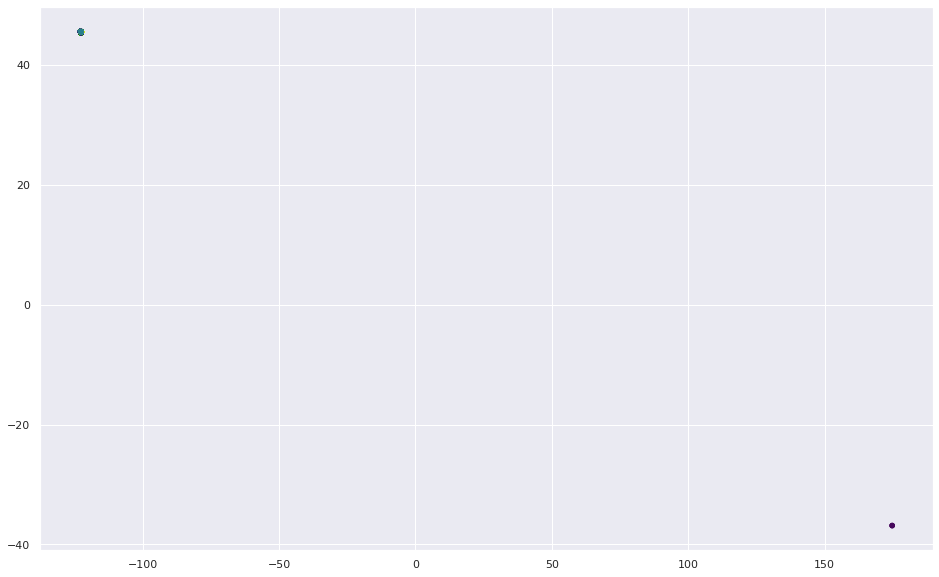

In [16]:
plt.scatter(coord_array[:, 0], coord_array[:, 1], c=y_kmeans, s=20, cmap='viridis')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(preference=-50).fit(coord_array)

In [ ]:
cluster_centers_indices = af.cluster_centers_indices_
len(cluster_centers_indices)

In [1]:
route_df['cluster'] = kmeans.predict(coord_array)

NameError: name 'kmeans' is not defined

In [90]:
shst_df = route_df.groupby('cluster').apply(lambda x: {
    'type': 'FeatureCollection',
    'features': x.apply(lambda x: {
        'type': 'Feature',
        'properties': {
            'hash': x.hash
        },
        'geometry': {
            'type': 'Point',
            'coordinates': [x.coordinates[0], x.coordinates[1]]
        }
    }, axis=1).values.tolist()
})

In [91]:
def _request(session, url, data=None):
    """
    Internal helper for sending requests.

    Returns payload(s).
    """
    retries = 0
    res = None

    while res is None:
        try:
            res = session.post(url, data=data)
            res.raise_for_status()
        except Exception as err:
            res = None
            retries = retries + 1
            if retries > 3:
                print(
                    f"Unable to retrieve response from {url} after 3 tries.  Aborting...")

            print(
                f"Error while retrieving: {err}. Retrying in {retries * 10} seconds... (retry {retries}/3)")
            time.sleep(retries * 10)

    return res

In [92]:
session.headers.update({"Content-Type": "application/json" })
session.headers.update({"Accept": "application/json"})

cores = cpu_count() #Number of CPU cores on your system
executor = ThreadPoolExecutor(max_workers=cores*4)
shst = shst_df.map(lambda x: executor.submit(
    _request, session, 'http://sharedstreets:3000/api/v1/match/point/bike', data=json.dumps(x)))

Error while retrieving: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')). Retrying in 10 seconds... (retry 1/3)
Error while retrieving: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')). Retrying in 10 seconds... (retry 1/3)
Error while retrieving: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')). Retrying in 10 seconds... (retry 1/3)
Error while retrieving: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')). Retrying in 10 seconds... (retry 1/3)
Error while retrieving: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')). Retrying in 10 seconds... (retry 1/3)Error while retrieving: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')). Retrying in 10 seconds... (retry 1/3)

Error while retrieving: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')). Retrying in 10 seconds... (retry 1/3)
Error 

In [94]:
shst.map(lambda x: 1 if x.done() else 0).sum()

50

In [95]:
def safe_result(x):
    try:
        return x.result().json()
    except:
        return None

In [96]:
shst_df = shst.map(safe_result)

In [97]:
shst_df = pd.DataFrame({
    'feature': np.concatenate(shst_df.map(lambda x: x['features']).values)
})

In [98]:
shst_df['hash'] = shst_df.feature.map(lambda x: x['properties']['hash'])
shst_df['candidates'] = shst_df.feature.map(lambda x: x['properties']['shstCandidates'])

In [99]:
shst_df.head()

,feature,hash,candidates
0,"{'type': 'Feature', 'properties': {'hash': '40...",401ebb0dcfe5220a45a24216d35ea281,[{'geometryId': 'b0128b9c21dd5a010ee41e5757749...
1,"{'type': 'Feature', 'properties': {'hash': '45...",45333c07a02d37426153ac858d07af57,[{'geometryId': '34150595cb50ee3a3be7ab022f464...
2,"{'type': 'Feature', 'properties': {'hash': '8e...",8e2ef6a17c9f4be0d5ac3f79374938e9,[]
3,"{'type': 'Feature', 'properties': {'hash': 'aa...",aab1900487a21606815825748763aa48,[]
4,"{'type': 'Feature', 'properties': {'hash': '2d...",2d127e36f3f956ee3809553603c4fb48,[]


In [100]:
len(shst_df)

46742

In [102]:
route_df = route_df.merge(shst_df, on='hash').head()

,trip_id,provider_id,device_id,vehicle_type,feature_x,timestamp,coordinates,geometry,hash,cluster,feature_y,candidates
0,3d639536-c16c-45a9-b694-c8cacc09f998,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,31a10fab-c24d-4655-bfa7-1ae100bdbb4c,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561760590000,"[-122.64338, 45.516919]",POINT (-122.64338 45.516919),05762c217de5839873598f19e9f6d92c,11,"{'type': 'Feature', 'properties': {'hash': '05...",[{'geometryId': 'f84d6cb509518b10c16327306f750...
1,3d639536-c16c-45a9-b694-c8cacc09f998,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,31a10fab-c24d-4655-bfa7-1ae100bdbb4c,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561768264000,"[-122.672453, 45.502695]",POINT (-122.672453 45.502695),51dd2c0777ea79613fa8cf9238c43036,14,"{'type': 'Feature', 'properties': {'hash': '51...",[{'geometryId': '7b6e6ed07bb6146af6e0d0117e8da...
2,92a915b3-06d6-432a-bd29-f7663ef8bd12,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,29a19b51-d9dd-4394-b688-092492e10670,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561760666000,"[-122.6454, 45.51653]",POINT (-122.6454 45.51653),d7ac60fb0f399e644cb755ffd6b666ab,11,"{'type': 'Feature', 'properties': {'hash': 'd7...",[{'geometryId': 'bceb8e41738f5b22a4a294d9c6dba...
3,92a915b3-06d6-432a-bd29-f7663ef8bd12,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,29a19b51-d9dd-4394-b688-092492e10670,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561760809377,"[-122.64985, 45.51719000000001]",POINT (-122.64985 45.51719000000001),0eb94a056a66ee914d0ca369141e3fbb,10,"{'type': 'Feature', 'properties': {'hash': '0e...",[{'geometryId': '6f8bf3c5714ebbd08d8a20394056a...
4,92a915b3-06d6-432a-bd29-f7663ef8bd12,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,29a19b51-d9dd-4394-b688-092492e10670,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561760952754,"[-122.65355, 45.51727]",POINT (-122.65355 45.51727),529572f073be524081f4c1b45dc89285,10,"{'type': 'Feature', 'properties': {'hash': '52...",[]


In [103]:
route_df.groupby('cluster').count().describe()

,trip_id,provider_id,device_id,vehicle_type,feature,timestamp,coordinates,geometry,hash
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,934.840000,934.840000,934.840000,934.840000,934.840000,934.840000,934.840000,934.840000,934.840000
std,850.993018,850.993018,850.993018,850.993018,850.993018,850.993018,850.993018,850.993018,850.993018
min,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
25%,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
50%,602.500000,602.500000,602.500000,602.500000,602.500000,602.500000,602.500000,602.500000,602.500000
75%,1297.500000,1297.500000,1297.500000,1297.500000,1297.500000,1297.500000,1297.500000,1297.500000,1297.500000
max,3251.000000,3251.000000,3251.000000,3251.000000,3251.000000,3251.000000,3251.000000,3251.000000,3251.000000


In [76]:
route_df.drop_duplicates(subset='hash').groupby('cluster').count().describe()

,trip_id,provider_id,device_id,vehicle_type,feature,timestamp,coordinates,geometry,hash
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,934.840000,934.840000,934.840000,934.840000,934.840000,934.840000,934.840000,934.840000,934.840000
std,944.347618,944.347618,944.347618,944.347618,944.347618,944.347618,944.347618,944.347618,944.347618
min,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
25%,287.750000,287.750000,287.750000,287.750000,287.750000,287.750000,287.750000,287.750000,287.750000
50%,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000
75%,1261.500000,1261.500000,1261.500000,1261.500000,1261.500000,1261.500000,1261.500000,1261.500000,1261.500000
max,3899.000000,3899.000000,3899.000000,3899.000000,3899.000000,3899.000000,3899.000000,3899.000000,3899.000000


In [59]:
route_df.sort_values(
    by=['trip_id', 'timestamp'], ascending=True
).reset_index(drop=True).head()

,trip_id,provider_id,device_id,vehicle_type,feature,timestamp,coordinates,geometry,hash,cluster
0,001c65e8-8b3c-44e3-bcd9-1c2bae2f1ae4,70aa475d-1fcd-4504-b69c-2eeb2107f7be,1f358c81-0eaa-4370-ad68-29c91bb2201e,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561769131959,"[-122.6858332, 45.5344796]",POINT (-122.6858332 45.5344796),70d32eb63f7424357d935c498702b460,43
1,001c65e8-8b3c-44e3-bcd9-1c2bae2f1ae4,70aa475d-1fcd-4504-b69c-2eeb2107f7be,1f358c81-0eaa-4370-ad68-29c91bb2201e,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561769131959,"[-122.6858332, 45.5344796]",POINT (-122.6858332 45.5344796),70d32eb63f7424357d935c498702b460,43
2,001c65e8-8b3c-44e3-bcd9-1c2bae2f1ae4,70aa475d-1fcd-4504-b69c-2eeb2107f7be,1f358c81-0eaa-4370-ad68-29c91bb2201e,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561769131959,"[-122.6858332, 45.5344796]",POINT (-122.6858332 45.5344796),70d32eb63f7424357d935c498702b460,43
3,001c65e8-8b3c-44e3-bcd9-1c2bae2f1ae4,70aa475d-1fcd-4504-b69c-2eeb2107f7be,1f358c81-0eaa-4370-ad68-29c91bb2201e,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561769131959,"[-122.6858332, 45.5344796]",POINT (-122.6858332 45.5344796),70d32eb63f7424357d935c498702b460,43
4,001c65e8-8b3c-44e3-bcd9-1c2bae2f1ae4,70aa475d-1fcd-4504-b69c-2eeb2107f7be,1f358c81-0eaa-4370-ad68-29c91bb2201e,scooter,"{'type': 'Feature', 'geometry': {'type': 'Poin...",1561769142437,"[-122.69062, 45.53215]",POINT (-122.69062 45.53215),f8b901afb626cb7d0b1d8be9754c63d1,43


In [47]:
route_df = gpd.GeoDataFrame(route_df.sort_values(
    by=['trip_id', 'timestamp'], ascending=True
).reset_index(drop=True).copy())
route_df.crs = {'init': 'epsg:4326'}
route_df['datetime'] = route_df.timestamp.map(
    lambda x: datetime.fromtimestamp(x / 1000).astimezone(timezone("US/Pacific")))
route_df['datetime'] = route_df.datetime.dt.round("L")
route_df['datetime'] = route_df.datetime.map(
    lambda x: datetime.replace(x, tzinfo=None))
route_df['date_key'] = route_df.datetime.map(
    lambda x: int(x.strftime('%Y%m%d')))
# Generate a hash to aid in merge operations
route_df['hash'] = route_df.apply(lambda x: hashlib.md5((
    x.trip_id + x.device_id + x.provider_id +
    x.datetime.strftime('%d%m%Y%H%M%S%f')
).encode('utf-8')).hexdigest(), axis=1)
route_df['datetime'] = route_df.datetime.map(
    lambda x: x.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])


In [48]:
route_df = route_df.to_crs(epsg=3857)

route_df['x'] = route_df.geometry.map(lambda g: g.x)
route_df['y'] = route_df.geometry.map(lambda g: g.y)

route_by_trip = route_df.groupby(['trip_id'])

route_df['nt'] = route_by_trip.timestamp.shift(-1)
route_df['nx'] = route_by_trip.x.shift(-1)
route_df['ny'] = route_by_trip.y.shift(-1)

# drop destination
route_df = route_df.dropna()

route_df['dx'] = route_df.apply(
    lambda x: x.nx - x.x, axis=1)
route_df['dy'] = route_df.apply(
    lambda x: x.ny - x.y, axis=1)
route_df['dt'] = route_df.apply(
    lambda x: (x.nt - x.timestamp) / 1000, axis=1)

def find_bearing(hit):
    deg = atan2(hit.dx, hit.dy) / pi * 180
    if deg < 0:
        deg = deg + 360
    return deg

def find_speed(hit):
    if hit['dt'] <= 0:
        return 0

    d = sqrt(pow((hit.dx), 2) + pow((hit.dy), 2))

    return d / hit['dt']

route_df['bearing'] = route_df.apply(find_bearing, axis=1)
route_df['speed'] = route_df.apply(find_speed, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [52]:
route_df['candidates'] = route_df.feature.map(lambda x: x['properties']['shstCandidates'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
lens = [len(item) for item in route_df['candidates']]
shst_df = pd.DataFrame( {
    "date_key" : np.repeat(route_df['date_key'].values,lens),
    "hash" : np.repeat(route_df['hash'].values,lens),
    "datetime" : np.repeat(route_df['datetime'].values,lens),
    "trip_id" : np.repeat(route_df['trip_id'].values,lens),
    "provider_id" : np.repeat(route_df['provider_id'].values,lens),
    "vehicle_type": np.repeat(route_df['vehicle_type'].values, lens),
    "bearing": np.repeat(route_df['bearing'].values, lens),
    "speed": np.repeat(route_df['speed'].values, lens),
    "candidate" : np.concatenate(route_df['candidates'].values),
})

ValueError: operands could not be broadcast together with shape (1,) (43756,)

In [77]:
shst_df.head()

,hash,trip_id,provider_id,timestamp,vehicle_type,bearing,speed,candidate,shstBearing,shst_geometry_id,shst_reference_id,score,bearing_diff
0,251862b99984514c48b00aba6fd4dd31,088dc7d8-1e52-4a15-beca-0ec11b37cfea,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,1567293572000,scooter,86.973989,1.352729,{'geometryId': '55784fa265b8d566cde06a6df01b85...,88.759973,55784fa265b8d566cde06a6df01b85c0,637c5f9155e18ef19f143e0b3d8778fb,0.000000,1.785985
1,8ee02617a94293476c3f05a4b1d0c19d,088dc7d8-1e52-4a15-beca-0ec11b37cfea,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,1567293661000,scooter,111.450226,2.392075,{'geometryId': 'd7989c1f9a59e5ca388d711a7404b1...,88.247292,d7989c1f9a59e5ca388d711a7404b16d,c6bcf38ea4a9288f3570e2bac43e2987,0.000000,23.202934
2,7940eea1dcc8a16ead5fb8870439a796,09ea1689-54e6-4c7b-b22a-f57e59080630,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,1567293156000,scooter,88.352326,4.460869,{'geometryId': 'd30234716cc8f4c4a64014340bc0a6...,268.559841,d30234716cc8f4c4a64014340bc0a64a,3cfd6cda329485e7c7c1d8d9c21927bb,0.522278,180.207515
3,7940eea1dcc8a16ead5fb8870439a796,09ea1689-54e6-4c7b-b22a-f57e59080630,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,1567293156000,scooter,88.352326,4.460869,{'geometryId': 'd30234716cc8f4c4a64014340bc0a6...,88.559841,d30234716cc8f4c4a64014340bc0a64a,1e590f4ae30690615e300924703f72bb,0.522278,0.207515
4,7940eea1dcc8a16ead5fb8870439a796,09ea1689-54e6-4c7b-b22a-f57e59080630,63f13c48-34ff-49d2-aca7-cf6a5b6171c3,1567293156000,scooter,88.352326,4.460869,{'geometryId': '0f5ab2d8527c3aeca04e43f49b3c63...,178.596859,0f5ab2d8527c3aeca04e43f49b3c6324,a4b7ec05dd336a9c5bbf1fa25e2b70d0,1.789390,90.244533


In [73]:
shst_df['shstBearing'] = shst_df.candidate.map(lambda x: x['bearing'])
shst_df['shst_geometry_id'] = shst_df.candidate.map(lambda x: x['geometryId'])
shst_df['shst_reference_id'] = shst_df.candidate.map(lambda x: x['referenceId'])
shst_df['score'] = shst_df.candidate.map(lambda x: x['score'] if 'score' in x else 0)

In [74]:
def normalizeAngle(angle):
    if angle < 0:
        angle = angle + 360
    return angle
shst_df['bearing_diff'] = shst_df.apply(lambda x: fabs(normalizeAngle(x.bearing) - normalizeAngle(x.shstBearing)), axis=1)

In [76]:
shst_df.sort_values(
    by=['hash', 'bearing_diff', 'score']
).drop_duplicates(
    subset=['hash'],
    keep='first'
).drop_duplicates(
    subset=['trip_id', 'shst_geometry_id'],
    keep='last'
)[[
    'provider_id',
    'date_key',
    'shst_geometry_id',
    'shst_reference_id',
    'hash',
    'datetime',
    'vehicle_type',
    'propulsion_type',
    'bearing',
    'speed',
    'seen',
]]

KeyError: "['datetime', 'seen', 'date_key', 'propulsion_type'] not in index"

In [133]:
gpd.GeoDataFrame(route_df)[['geometry', 'hash']].to_file('../.data/shst_matches.geojson', driver='GeoJSON')

In [45]:
route_df.shstCandidates.map(lambda x: 1 if x.empty else 0).sum()

6541

In [47]:
route_df[route_df.shstCandidates.map(lambda x: x.empty)][['geometry', 'hash']].to_file('../.data/unmatched_shst.geojson', driver='GeoJSON')

In [29]:
import joblib
joblib.dump(kmeans, 'kmeans.pkl')

['kmeans.pkl']